In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K

In [3]:
# get the data containing MRIs which have tumor masks
df_brain = pd.read_csv('data_mask.csv')
df_brain_mask = df_brain[df_brain['mask']==1]
df_brain_mask.shape

(1373, 4)

In [4]:
# split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(df_brain_mask, test_size=0.2, random_state=12345)
X_valid, X_test = train_test_split(X_valid, test_size=0.5, random_state=12345)

In [5]:
# create seperate list for imageId, classId to pass into the generator
# train_image = ['C:/Users/Victiny/Python_Project/Data_brain_tumor/' + i for i in X_train.image_path]
# train_mask = ['C:/Users/Victiny/Python_Project/Data_brain_tumor/' + i for i in X_train.mask_path]

# valid_image = ['C:/Users/Victiny/Python_Project/Data_brain_tumor/' + i for i in X_valid.image_path]
# valid_mask = ['C:/Users/Victiny/Python_Project/Data_brain_tumor/' + i for i in X_valid.mask_path]
train_image = list(X_train.image_path)
train_mask = list(X_train.mask_path)

valid_image = list(X_valid.image_path)
valid_mask = list(X_valid.mask_path)

In [6]:
# utilities file contains the code for custom loss function and custom data generator
from utilities import DataGenerator

# create image generators
train_generator = DataGenerator(train_image, train_mask)
valid_generator = DataGenerator(valid_image, valid_mask)

In [7]:
def resblock(X, f):
    # make a copy of input
    X_copy = X
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(f, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # short path
    X_copy = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # add the output from main path  and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

In [8]:
# function to upscale and concatenate the values passed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])
    
    return merge

In [9]:
input_shape = (256, 256, 3)

# input tensor shape
X_input = Input(input_shape)

# stage 1
conv1_in = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size=(2,2))(conv1_in)

# stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size=(2,2))(conv2_in)

# stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size=(2,2))(conv3_in)

# stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size=(2,2))(conv4_in)

# stage 5 (bottle neck)
conv5_in = resblock(pool_4, 256)

# upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# final output
output = Conv2D(1, (1,1), padding='same', activation='sigmoid')(up_4)

model_seg = Model(inputs=X_input, outputs=output)

In [10]:
model_seg.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
# utilities file contains the code for custom loss function and custom data generator
from utilities import focal_tversky, tversky_loss, tversky

In [12]:
# compile the model
model_seg.compile(optimizer=Adam(lr=0.05, epsilon=0.1), loss=focal_tversky, metrics=[tversky])

In [13]:
# use early stoppingto exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath='resunet_weights.hdf5', verbose=1, save_best_only=True)

In [14]:
history = model_seg.fit(train_generator, 
                        epochs=200, 
                        validation_data=valid_generator,
                        verbose=1,
                        callbacks=[checkpointer, earlystopping])

Train for 68 steps, validate for 8 steps
Epoch 1/200
67/68 [============================>.] - ETA: 7s - loss: 0.9135 - tversky: 0.1135 
Epoch 00001: val_loss improved from inf to 0.89986, saving model to resunet_weights.hdf5
68/68 [==============================] - 541s 8s/step - loss: 0.9136 - tversky: 0.1134 - val_loss: 0.8999 - val_tversky: 0.1311
Epoch 2/200
67/68 [============================>.] - ETA: 7s - loss: 0.8352 - tversky: 0.2129 
Epoch 00002: val_loss improved from 0.89986 to 0.76904, saving model to resunet_weights.hdf5
68/68 [==============================] - 516s 8s/step - loss: 0.8330 - tversky: 0.2156 - val_loss: 0.7690 - val_tversky: 0.2950
Epoch 3/200
67/68 [============================>.] - ETA: 7s - loss: 0.5154 - tversky: 0.5822 
Epoch 00003: val_loss improved from 0.76904 to 0.46343, saving model to resunet_weights.hdf5
68/68 [==============================] - 527s 8s/step - loss: 0.5131 - tversky: 0.5846 - val_loss: 0.4634 - val_tversky: 0.6393
Epoch 4/200
67/

In [21]:
# save the model architecture to json file for future use
model_json = model_seg.to_json()
with open('segment_resunet_model.json', 'w') as json_file:
    json_file.write(model_json)

In [23]:
with open('segment_resunet_model.json', 'r') as json_file:
    json_saved_model = json_file.read()
# load the model architecture
model_seg = tf.keras.models.model_from_json(json_saved_model)
model_seg.load_weights('resunet_weights.hdf5')
model_seg.compile(loss=focal_tversky, optimizer=Adam(lr=0.05, epsilon=0.1), metrics=[tversky])

In [152]:
from importlib import reload
import utilities
reload(utilities)
from utilities import segmentation

# making prediction
image, mask = segmentation(X_test, model_seg)

In [153]:
df_seg = pd.DataFrame({'image_path': image, 'mask_segment': mask})
df_seg.head()

,image_path,mask_segment
0,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20...,"[[[[8.940697e-08], [2.0861626e-07], [2.9802322..."
1,TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_11...,"[[[[4.172325e-07], [1.3411045e-06], [2.503395e..."
2,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_28...,"[[[[3.2782555e-07], [1.1920929e-06], [2.324581..."
3,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21...,"[[[[2.682209e-07], [9.536743e-07], [1.7285347e..."
4,TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_22...,"[[[[2.3841858e-07], [7.1525574e-07], [1.251697..."


In [155]:
# merge the dataframe containing segmentation results with the original test set
df_seg = X_test.merge(df_seg, on='image_path')
df_seg.head()

,patient_id_x,image_path,mask_path_x,mask_x,patient_id_y,mask_path_y,mask_y,mask_segment
0,TCGA_FG_7643_20021104,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20...,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20...,1,TCGA_FG_7643_20021104,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20...,1,"[[[[8.940697e-08], [2.0861626e-07], [2.9802322..."
1,TCGA_DU_7013_19860523,TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_11...,TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_11...,1,TCGA_DU_7013_19860523,TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_11...,1,"[[[[4.172325e-07], [1.3411045e-06], [2.503395e..."
2,TCGA_HT_7874_19950902,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_28...,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_28...,1,TCGA_HT_7874_19950902,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_28...,1,"[[[[3.2782555e-07], [1.1920929e-06], [2.324581..."
3,TCGA_FG_7634_20000128,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21...,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21...,1,TCGA_FG_7634_20000128,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21...,1,"[[[[2.682209e-07], [9.536743e-07], [1.7285347e..."
4,TCGA_FG_8189_20030516,TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_22...,TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_22...,1,TCGA_FG_8189_20030516,TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_22...,1,"[[[[2.3841858e-07], [7.1525574e-07], [1.251697..."


In [156]:
df_seg.drop(columns=['patient_id_y','mask_path_y','mask_y'])
df_seg.head()

,patient_id_x,image_path,mask_path_x,mask_x,patient_id_y,mask_path_y,mask_y,mask_segment
0,TCGA_FG_7643_20021104,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20...,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20...,1,TCGA_FG_7643_20021104,TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20...,1,"[[[[8.940697e-08], [2.0861626e-07], [2.9802322..."
1,TCGA_DU_7013_19860523,TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_11...,TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_11...,1,TCGA_DU_7013_19860523,TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_11...,1,"[[[[4.172325e-07], [1.3411045e-06], [2.503395e..."
2,TCGA_HT_7874_19950902,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_28...,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_28...,1,TCGA_HT_7874_19950902,TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_28...,1,"[[[[3.2782555e-07], [1.1920929e-06], [2.324581..."
3,TCGA_FG_7634_20000128,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21...,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21...,1,TCGA_FG_7634_20000128,TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_21...,1,"[[[[2.682209e-07], [9.536743e-07], [1.7285347e..."
4,TCGA_FG_8189_20030516,TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_22...,TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_22...,1,TCGA_FG_8189_20030516,TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_22...,1,"[[[[2.3841858e-07], [7.1525574e-07], [1.251697..."


In [104]:
import random
sample_id = [random.randint(0, len(X_test)-1) for _ in range(5)]
sample_id

[59, 82, 86, 71, 79]

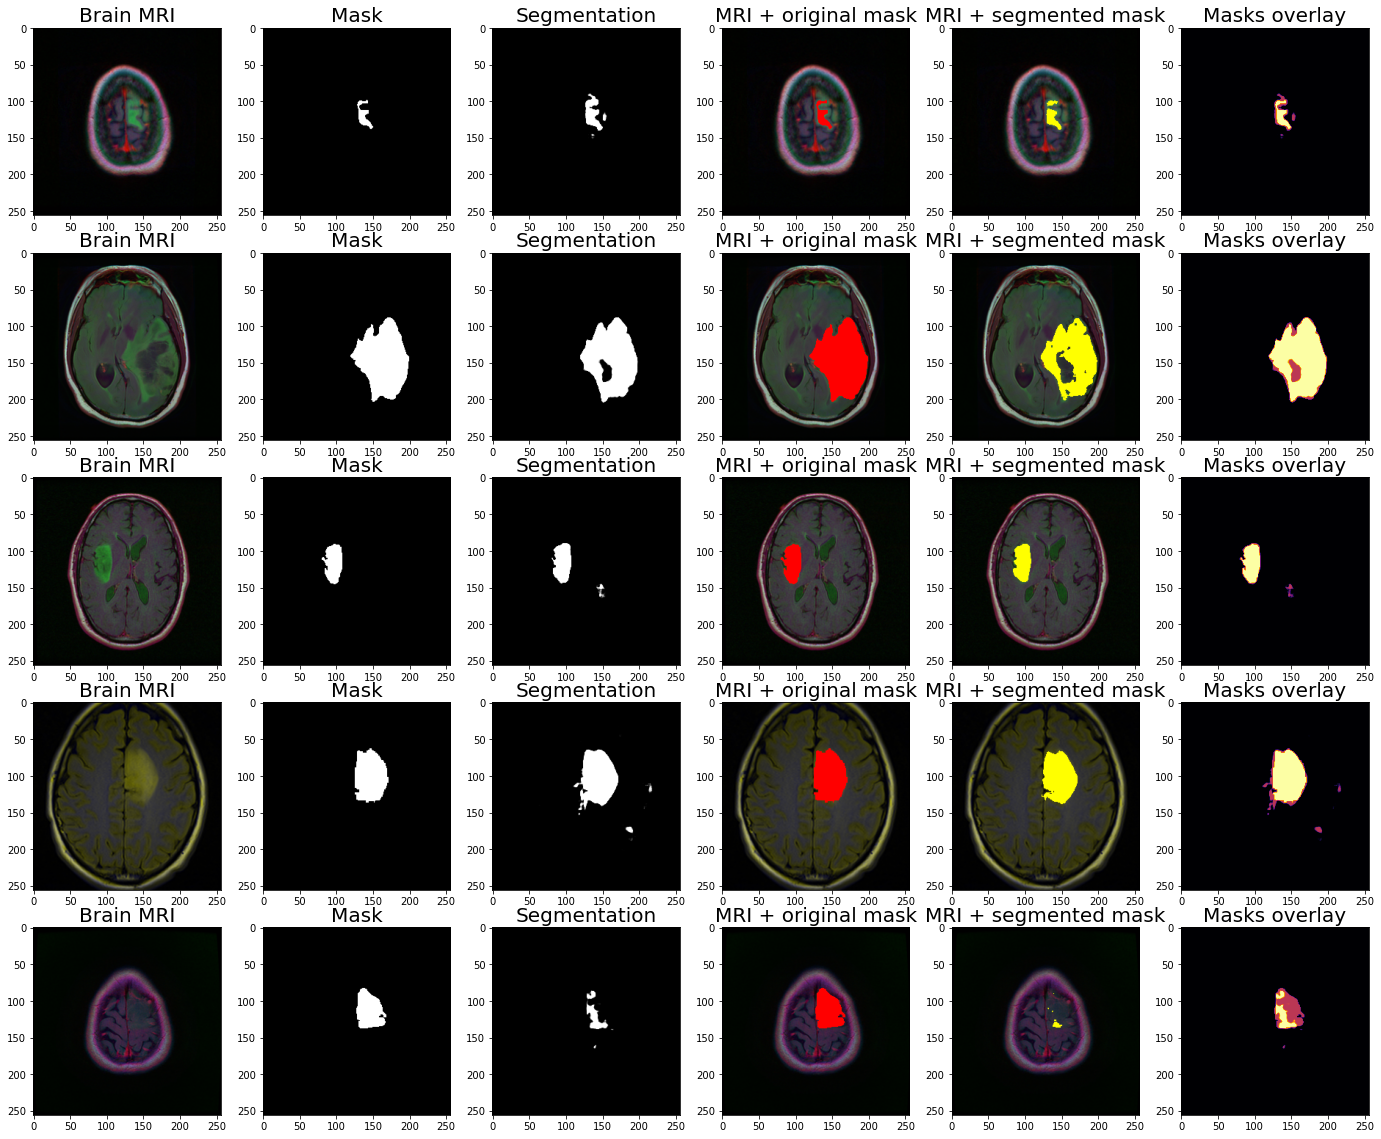

In [182]:
sample_id =[0,1,2,10, 15]
fig = plt.figure(figsize=(24,20))
for i in range(5):
    idx = sample_id[i]
    raw = io.imread('C:/Users/Victiny/Python_Project/Data_brain_tumor/' + df_seg.image_path[idx])
    raw = cv2.cvtColor(raw, cv2.COLOR_BGR2RGB)
    mask = io.imread('C:/Users/Victiny/Python_Project/Data_brain_tumor/' + df_seg.mask_path_x[idx])
#     mask2 = cv2.imread('C:/Users/Victiny/Python_Project/Data_brain_tumor/' + df_seg.mask_path_x[idx])
    segm = df_seg.mask_segment[idx].squeeze()
    # create a red mask for overlapping
    raw_mask = np.copy(raw)
    raw_mask[mask==255] = (255, 0, 0)
    # create a yellow mask for overlapping
    raw_segm = np.copy(raw)
    raw_segm[segm==1] = (255, 255, 0)
    # overlap masks
    overlap = (mask/255 + segm)/2
    
    ax1 = fig.add_subplot(5, 6, 6*i+1)
    ax1.imshow(raw)
    ax1.set_title('Brain MRI', fontsize=20)
    ax2 = fig.add_subplot(5, 6, 6*i+2)
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Mask', fontsize=20)
    ax3 = fig.add_subplot(5, 6, 6*i+3)
    ax3.imshow(segm, cmap='gray')
    ax3.set_title('Segmentation', fontsize=20)
    ax4 = fig.add_subplot(5, 6, 6*i+4)
    ax4.imshow(raw_mask)
    ax4.set_title('MRI + original mask', fontsize=20)
    ax5 = fig.add_subplot(5, 6, 6*i+5)
    ax5.imshow(raw_segm)
    ax5.set_title('MRI + segmented mask', fontsize=20)
    ax6 = fig.add_subplot(5, 6, 6*i+6)
    ax6.imshow(overlap, cmap='inferno')
    ax6.set_title('Masks overlay', fontsize=20)

In [196]:
dice = []
for i in range(len(X_test)):
    mask = io.imread('C:/Users/Victiny/Python_Project/Data_brain_tumor/' + df_seg.mask_path_x[i])
    segm = df_seg.mask_segment[i].squeeze().astype(np.int8)
    overlay = mask/255 + segm
    mask_and_segm = sum(overlay[overlay==2])
    mask_or_segm = sum(overlay[overlay>0])
    dice.append(mask_and_segm / mask_or_segm)
print('%.4f'% (sum(dice)/len(dice)))

0.7925


Text(0.5, 0, 'Dice Score')

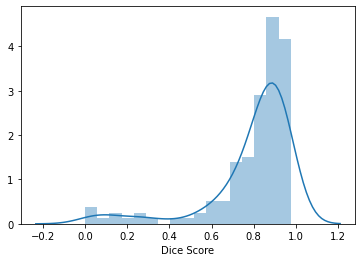

In [186]:
sns.distplot(dice)
plt.xlabel('Dice Score')